## Kinda live dashboard :)

In [41]:
# Imports and configuration
import json
import time
from pathlib import Path
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.dates as mdates
from IPython.display import clear_output, display

pd.options.mode.chained_assignment = None

# Refresh interval and number of points per device
REFRESH_SECONDS = 5
MAX_POINTS_PER_DEVICE = 20

# Unified recorded CSV
RECORDED_CSV = Path('all_devices_recorded_data.csv')
SENT_LOG = Path('sent_messages.csv')

# Plot limits per sensor
Y_LIMITS = {
    'humidity': (0, 100),
    'temperature': (0, 50),
    'light': (0, 500),
}

# Matplotlib config
plt.style.use('seaborn-v0_8-darkgrid')


def load_config(path='config.json'):
    p = Path(path)
    if not p.exists():
        return {}
    try:
        with p.open('r', encoding='utf-8') as f:
            return json.load(f)
    except Exception:
        return {}


In [42]:
def load_df(path: Path = RECORDED_CSV) -> pd.DataFrame | None:
    """Load and normalize the recorded CSV.

    Returns a DataFrame with columns including: device_id, sensor_type (lowercase), datetime, value,
    send_ts, receive_ts, latency_ms (numeric if present).
    """
    import io
    if not path.exists():
        return None

    # Fast attempt: read normally
    try:
        df = pd.read_csv(path)
    except Exception:
        # Fallback: try to repair common broken-line issues by joining lines until we have enough commas
        raw = path.read_text(encoding='utf-8', errors='replace').splitlines()
        if not raw:
            return None
        header = raw[0]
        rows = []
        buf = ''
        for line in raw[1:]:
            if not line.strip():
                continue
            if buf:
                buf += ' ' + line.strip()
            else:
                buf = line.strip()
            # heuristic: accept line when it has at least 5 commas (6 fields)
            if buf.count(',') >= 5:
                rows.append(buf)
                buf = ''
        if buf:
            rows.append(buf)
        csv_text = header + '\n' + '\n'.join(rows)
        df = pd.read_csv(io.StringIO(csv_text))

    # Normalize column names (some files may include extra columns)
    cols = list(df.columns)
    # Ensure at least the first 6 columns are present
    if len(cols) < 6:
        return None

    # If the CSV has extra columns (send_ts, receive_ts, latency_ms), keep them
    # Standardize first six column names
    std_cols = ['device_id', 'time', 'date', 'protocol', 'sensor_type', 'value']
    # If header is not standard, coerce
    if cols[:6] != std_cols:
        df = df.iloc[:, :max(6, len(cols))]
        df.columns = std_cols + cols[6:]

    # Clean and normalize
    df['device_id'] = df['device_id'].astype(str).str.strip()
    df['sensor_type'] = df['sensor_type'].astype(str).str.strip().str.lower()
    df['time'] = df['time'].astype(str).str.strip()
    df['date'] = df['date'].astype(str).str.strip()

    # datetime: prefer date+time, else try receive_ts/send_ts
    df['datetime'] = pd.to_datetime(df['date'] + ' ' + df['time'], errors='coerce')
    if 'receive_ts' in df.columns:
        mask = df['datetime'].isna()
        if mask.any():
            df.loc[mask, 'datetime'] = pd.to_datetime(df.loc[mask, 'receive_ts'], errors='coerce')
    if 'send_ts' in df.columns:
        mask = df['datetime'].isna()
        if mask.any():
            df.loc[mask, 'datetime'] = pd.to_datetime(df.loc[mask, 'send_ts'], errors='coerce')

    # value numeric
    df['value'] = pd.to_numeric(df['value'].astype(str).str.replace(',', '').str.strip(), errors='coerce')

    # latency numeric if present
    if 'latency_ms' in df.columns:
        df['latency_ms'] = pd.to_numeric(df['latency_ms'], errors='coerce')

    # drop rows without datetime
    df = df.dropna(subset=['datetime'])

    # keep relevant columns
    return df


In [43]:
def live_dashboard(refresh_seconds: int = REFRESH_SECONDS, max_points: int = MAX_POINTS_PER_DEVICE):
    """Live dashboard: left column = sensors (light, humidity, temperature), right column = metrics (PDR, avg latency, protocol counts).

    Shows last `max_points` points per device for each sensor. Refreshes every `refresh_seconds` seconds.
    """
    sensors = ['light', 'humidity', 'temperature']
    print(f'Reading recorded data from: {RECORDED_CSV}')
    print('Interrupt the cell to stop live updates')

    color_cycle = plt.rcParams['axes.prop_cycle'].by_key().get('color', None)

    while True:
        clear_output(wait=True)
        df = load_df(RECORDED_CSV)
        if df is None or df.empty:
            print(f'No data found in {RECORDED_CSV}. Retrying in {refresh_seconds}s...')
            try:
                time.sleep(refresh_seconds)
                continue
            except KeyboardInterrupt:
                print('Stopped by user')
                break

        devices = sorted(df['device_id'].unique())

        # Create grid: 3 rows x 2 cols
        fig, axs = plt.subplots(nrows=3, ncols=2, figsize=(14, 12), gridspec_kw={'width_ratios':[3,2]})

        for i, sensor in enumerate(sensors):
            ax = axs[i, 0]
            plotted = False
            for j, device in enumerate(devices):
                ddf = df[(df['device_id'] == device) & (df['sensor_type'] == sensor)]
                if ddf.empty:
                    continue
                ddf = ddf.sort_values('datetime').tail(max_points)
                ax.plot(ddf['datetime'], ddf['value'], marker='o', label=device, color=(color_cycle[j % len(color_cycle)] if color_cycle else None))
                plotted = True

            ax.set_title(f'{sensor.capitalize()} — last {max_points} points per device')
            ax.set_ylabel(sensor.capitalize())
            if sensor in Y_LIMITS:
                ax.set_ylim(Y_LIMITS[sensor])
            if plotted:
                ax.legend(loc='best', fontsize='small')
            else:
                ax.text(0.5, 0.5, 'No data for this sensor', ha='center', va='center', transform=ax.transAxes)
            ax.xaxis.set_major_formatter(mdates.DateFormatter('%H:%M:%S'))
            ax.tick_params(axis='x', rotation=30)

        # Metrics on right column
        pdr_df = compute_pdr(rec_df=df)

        # PDR (top-right)
        ax_pdr = axs[0, 1]
        ax_pdr.clear()
        if not pdr_df.empty and pdr_df['pdr'].notna().any():
            pdr_plot = pdr_df.dropna(subset=['pdr']).sort_values('pdr', ascending=False)
            ax_pdr.bar(pdr_plot['device_id'], pdr_plot['pdr'], color='C3')
            ax_pdr.set_ylim(0, 1.05)
            ax_pdr.set_title('Packet Delivery Ratio (PDR)')
            ax_pdr.tick_params(axis='x', rotation=45)
        else:
            ax_pdr.text(0.5, 0.5, 'No PDR data', ha='center', va='center', transform=ax_pdr.transAxes)

        # Avg latency (middle-right)
        ax_lat = axs[1, 1]
        ax_lat.clear()
        if not pdr_df.empty and pdr_df['avg_latency_ms'].notna().any():
            lat_plot = pdr_df.dropna(subset=['avg_latency_ms']).sort_values('avg_latency_ms', ascending=False)
            ax_lat.bar(lat_plot['device_id'], lat_plot['avg_latency_ms'], color='C4')
            ax_lat.set_title('Average latency (ms)')
            ax_lat.tick_params(axis='x', rotation=45)
        else:
            ax_lat.text(0.5, 0.5, 'No latency data', ha='center', va='center', transform=ax_lat.transAxes)

        # Protocol counts (bottom-right)
        ax_proto = axs[2, 1]
        ax_proto.clear()
        proto_counts = df['protocol'].value_counts()
        if not proto_counts.empty:
            ax_proto.bar(proto_counts.index.astype(str), proto_counts.values, color='C2')
            ax_proto.set_title('Records per protocol')
        else:
            ax_proto.text(0.5, 0.5, 'No protocol data', ha='center', va='center', transform=ax_proto.transAxes)

        plt.tight_layout()
        display(fig)
        plt.close(fig)

        print(f'Updated: {pd.Timestamp.now()} — refreshing in {refresh_seconds}s')
        try:
            time.sleep(refresh_seconds)
        except KeyboardInterrupt:
            print('Stopped by user')
            break


In [44]:
def compute_pdr(sent_path: Path = SENT_LOG, rec_df: pd.DataFrame | None = None) -> pd.DataFrame:
    """Compute per-device sent/received counts, PDR and latency stats.

    Returns DataFrame with device_id, sent, received, pdr, avg_latency_ms, median_latency_ms
    """
    import pandas as pd
    # load sent log
    if sent_path.exists():
        sent = pd.read_csv(sent_path)
        # normalize device_id
        if 'device_id' in sent.columns:
            sent['device_id'] = sent['device_id'].astype(str).str.strip()
        else:
            sent = pd.DataFrame(columns=['device_id'])
    else:
        sent = pd.DataFrame(columns=['device_id'])

    if rec_df is None:
        rec_df = load_df(RECORDED_CSV)
    if rec_df is None:
        rec_df = pd.DataFrame(columns=['device_id'])

    # counts
    sent_counts = sent.groupby('device_id').size().rename('sent') if not sent.empty else pd.Series(dtype=int)
    rec_counts = rec_df.groupby('device_id').size().rename('received') if not rec_df.empty else pd.Series(dtype=int)

    df = pd.concat([sent_counts, rec_counts], axis=1).fillna(0)

    # latency stats
    if 'latency_ms' in rec_df.columns:
        lat = rec_df.dropna(subset=['latency_ms']).groupby('device_id')['latency_ms'].agg(['mean','median']).rename(columns={'mean':'avg_latency_ms','median':'median_latency_ms'})
        df = df.join(lat, how='left')
    else:
        df['avg_latency_ms'] = np.nan
        df['median_latency_ms'] = np.nan

    df = df.reset_index().rename(columns={'index':'device_id'})
    if 'sent' in df.columns:
        df['sent'] = df['sent'].astype(int)
    else:
        df['sent'] = 0
    if 'received' in df.columns:
        df['received'] = df['received'].astype(int)
    else:
        df['received'] = 0

    df['pdr'] = df.apply(lambda r: (r['received'] / r['sent']) if r['sent'] > 0 else np.nan, axis=1)
    return df


def plot_latency_histogram(rec_df: pd.DataFrame | None = None, bins: int = 30):
    import matplotlib.pyplot as plt
    if rec_df is None:
        rec_df = load_df(RECORDED_CSV)
    if rec_df is None or 'latency_ms' not in rec_df.columns:
        print('No latency data available')
        return
    lat = rec_df['latency_ms'].dropna()
    if lat.empty:
        print('No latency values present')
        return
    plt.figure(figsize=(8,4))
    plt.hist(lat, bins=bins)
    plt.title('Latency histogram (ms)')
    plt.xlabel('Latency (ms)')
    plt.ylabel('Count')
    plt.show()


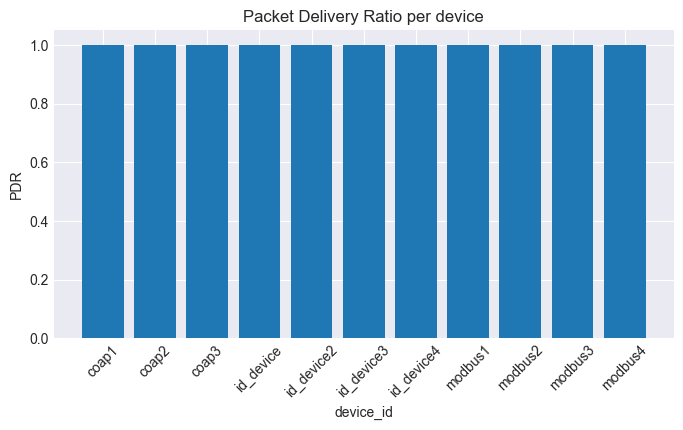

In [45]:
# Plot PDR and latency
pdr_df = compute_pdr()
if not pdr_df.empty:
    plt.figure(figsize=(8,4))
    plt.bar(pdr_df['device_id'], pdr_df['pdr'])
    plt.ylim(0,1.05)
    plt.title('Packet Delivery Ratio per device')
    plt.xlabel('device_id')
    plt.ylabel('PDR')
    plt.xticks(rotation=45)
    plt.show()


# Live device time-series dashboard

This notebook reads `config.json` to determine the active protocol (MQTT), then reads the recorded CSV (`all_devices_recorded_data.csv`) and draws three time-series plots: `light`, `humidity`, and `temperature`.

Behavior:
- The notebook will plot data for each device present in the CSV (limited to the `num_devices_mqtt` value from `config.json` when possible).
- Each plot shows up to the latest 20 points per device for that sensor type.
- The notebook refreshes the plots every 5 seconds so you can run `run_demo.py` in the background and watch a lightweight live dashboard.

Usage:
1. Start your simulation (e.g. `python run_demo.py`) in a terminal.
2. Run the code cells below. The plotting cell will keep updating until you stop it (Interrupt the cell to stop). Hit execute all cells for live results

In [ ]:
# Debug / quick-check cell

# df = load_df(RECORDED_CSV)
# if df is None:
#     print('No recorded CSV found or file empty')
# else:
#     print('Sensors:', sorted(df['sensor_type'].unique()))
#     print('Devices:', sorted(df['device_id'].unique()))
#     display(df.head(10))

#     # show first 10 rows for mqtt devices starting with 'id_device'
#     mqtt_df = df[df['device_id'].str.startswith('id_device')]
#     print('\nSample MQTT device rows:')
#     display(mqtt_df.head(10))

Sensors: ['humidity', 'light', 'temperature']
Devices: ['coap1', 'coap2', 'coap3', 'id_device', 'id_device2', 'id_device3', 'id_device4', 'modbus1', 'modbus2', 'modbus3', 'modbus4']


,device_id,time,date,protocol,sensor_type,value,send_ts,receive_ts,latency_ms,datetime
0,modbus1,18:12:58,2025-11-17,MODBUS,temperature,0.000000,2025-11-17T18:12:58.188100,2025-11-17T18:12:58.195286,NaN,2025-11-17 18:12:58.000000
1,id_device,20:09:59.370481,2004-03-01,MQTT,light,39.560000,2025-11-17T18:12:58.193589,2025-11-17T18:12:58.214341,NaN,2025-11-17 18:12:58.214341
2,modbus2,18:12:58,2025-11-17,MODBUS,temperature,0.000000,2025-11-17T18:12:58.209939,2025-11-17T18:12:58.232722,NaN,2025-11-17 18:12:58.000000
3,id_device2,06:38:25.981302,2004-03-03,MQTT,light,6.900000,2025-11-17T18:12:58.196089,2025-11-17T18:12:58.234843,NaN,2025-11-17 18:12:58.234843
4,coap1,18:12:58,2025-11-17,COAP,temperature,18.267325,2025-11-17T18:12:58.232344,2025-11-17T18:12:58.241147,NaN,2025-11-17 18:12:58.000000
5,id_device3,21:34:21.078937,2004-02-29,MQTT,light,43.240000,2025-11-17T18:12:58.196491,2025-11-17T18:12:58.253908,NaN,2025-11-17 18:12:58.253908
6,coap2,18:12:58,2025-11-17,COAP,temperature,26.319273,2025-11-17T18:12:58.232648,2025-11-17T18:12:58.260673,NaN,2025-11-17 18:12:58.000000
7,modbus3,18:12:58,2025-11-17,MODBUS,temperature,0.000000,2025-11-17T18:12:58.247930,2025-11-17T18:12:58.261463,NaN,2025-11-17 18:12:58.000000
8,id_device4,14:11:31.911734,2004-03-04,MQTT,humidity,29.578400,2025-11-17T18:12:58.196864,2025-11-17T18:12:58.267247,NaN,2025-11-17 18:12:58.267247
9,coap3,18:12:58,2025-11-17,COAP,temperature,21.878505,2025-11-17T18:12:58.232910,2025-11-17T18:12:58.273414,NaN,2025-11-17 18:12:58.000000



Sample MQTT device rows:


,device_id,time,date,protocol,sensor_type,value,send_ts,receive_ts,latency_ms,datetime
1,id_device,20:09:59.370481,2004-03-01,MQTT,light,39.5600,2025-11-17T18:12:58.193589,2025-11-17T18:12:58.214341,NaN,2025-11-17 18:12:58.214341
3,id_device2,06:38:25.981302,2004-03-03,MQTT,light,6.9000,2025-11-17T18:12:58.196089,2025-11-17T18:12:58.234843,NaN,2025-11-17 18:12:58.234843
5,id_device3,21:34:21.078937,2004-02-29,MQTT,light,43.2400,2025-11-17T18:12:58.196491,2025-11-17T18:12:58.253908,NaN,2025-11-17 18:12:58.253908
8,id_device4,14:11:31.911734,2004-03-04,MQTT,humidity,29.5784,2025-11-17T18:12:58.196864,2025-11-17T18:12:58.267247,NaN,2025-11-17 18:12:58.267247
11,id_device,22:54:25.410749,2004-03-01,MQTT,temperature,19.7532,2025-11-17T18:13:01.213402,2025-11-17T18:13:01.215099,NaN,2025-11-17 18:13:01.215099
12,id_device2,05:55:57.595254,2004-03-04,MQTT,light,0.9200,2025-11-17T18:13:01.230574,2025-11-17T18:13:01.232483,NaN,2025-11-17 18:13:01.232483
13,id_device3,22:59:22.082485,2004-02-29,MQTT,temperature,18.6262,2025-11-17T18:13:01.234199,2025-11-17T18:13:01.239835,NaN,2025-11-17 18:13:01.239835
14,id_device4,00:36:23.496752,2004-02-29,MQTT,temperature,19.0280,2025-11-17T18:13:01.234427,2025-11-17T18:13:01.246598,NaN,2025-11-17 18:13:01.246598
22,id_device,14:12:52.450033,2004-03-01,MQTT,light,172.9600,2025-11-17T18:13:04.223867,2025-11-17T18:13:04.225602,NaN,2025-11-17 18:13:04.225602
23,id_device2,02:15:51.803973,2004-03-01,MQTT,light,43.2400,2025-11-17T18:13:04.239823,2025-11-17T18:13:04.241273,NaN,2025-11-17 18:13:04.241273


KeyboardInterrupt: 

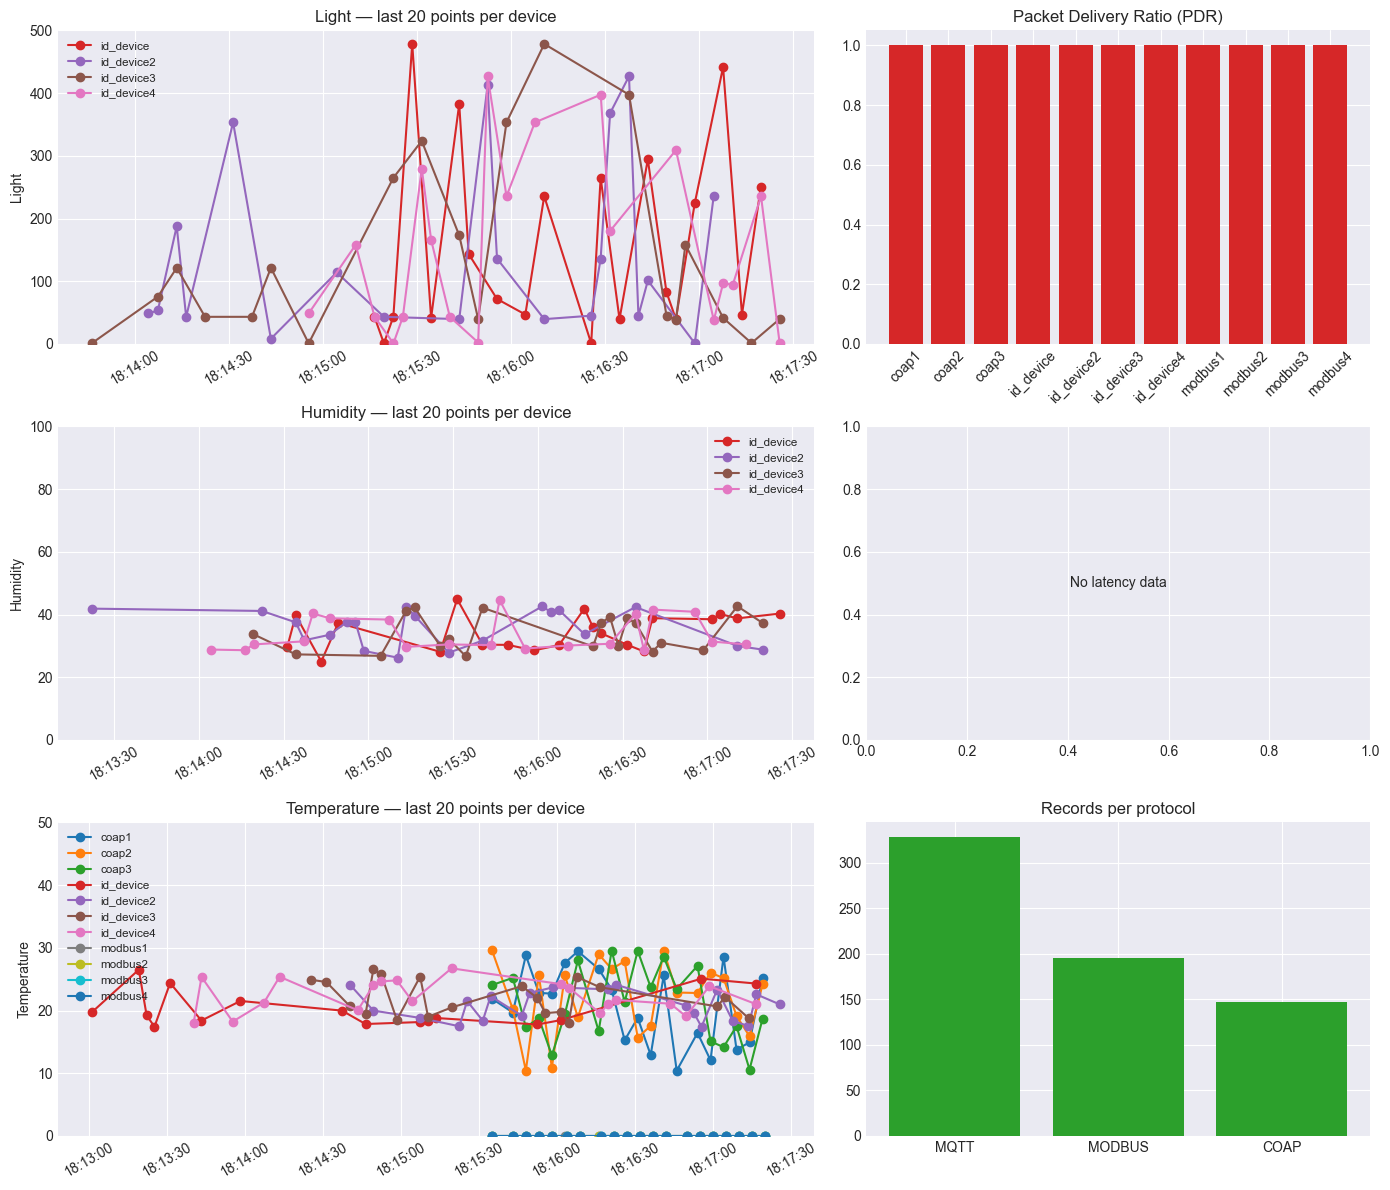

In [47]:
# Start the live dashboard (interrupt to stop)
live_dashboard()